In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import interpolate
import networkx as nx

import pandas as pd
from sklearn.cluster import KMeans

import landscape as ld
from networkx.algorithms import approximation as apx

from typing import List, Tuple

In [3]:
Point = Tuple[int, int]

# utils

In [4]:
def make_graph(Nx0: int, L: int, alpha: float, points: List[Point]) -> nx.Graph:
    """
    Descrption here.
    
    Args:    
        Nx0 (int): grid points on each direction
        L (int): size of the box
        A0 (float): strength of the potential at point location
        points (List[Point]): list of points where important nodes are
    
    Returns:
        nx.Graph: networkx graph
    
    """
    #compute landscape function
    fLand = ld.find_landscape(Nx0 = Nx0, L = L, A0 = 5000, points = points)
    
    # create square grid graph
    G = nx.grid_2d_graph(range(1,int(L)), range(1,int(L))) 

    print( 'number of original edges {}'.format(len(G.edges))) 
    
    # delete edges where the landscape function > alpha 
    for e in G.edges:
        x, y = 0.5*(np.array(e[0]) + np.array(e[1]))
        if fLand(x,y) > alpha:
            G.remove_edge(e[0],e[1])
            
    # delete nodes with degree 1
    ends = [ x[0] for x in G.degree() if x[1] <= 1]
    G.remove_nodes_from(ends)
            
    print( 'number of final edges {}'.format(len(G.edges)))
            
    return G

In [5]:
def get_pos(g: nx.Graph) -> dict:
    return dict( (n, n) for n in g.nodes() )

In [6]:
def make_graph_plot(Nx0: int, L: int, alpha: float, points: List[Point]):
    #make graph 
    G = make_graph(Nx0, L, alpha, points)
    pos = dict( (n, n) for n in G.nodes() )
    
    # get points for scatter plot
    xpoints = [point[0] for point in points]
    ypoints = [point[1] for point in points]
    
    # plotology 
    fig, ax = plt.subplots(figsize=(4,4));

    plt.xlim(0, L)
    plt.ylim(0, L)

    nx.draw_networkx_edges(G, pos, ax = ax, with_labels = False)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    # add scatter plot
    plt.scatter(xpoints, ypoints)
    plt.show()
    
    return G

In [7]:
def make_naive_steiner_plot(G: nx.Graph, L: int, points: List[Point]):
    
    # approximate steiner tree
    G_st = apx.steinertree.steiner_tree(G, points, weight='length') 
    print('The number of edges of the Steiner tree is '+ str(G_st.number_of_edges()))
    
    xpoints = [point[0] for point in points]
    ypoints = [point[1] for point in points]

    fig, ax = plt.subplots(figsize=(6,6)); plt.xlim(0, L); plt.ylim(0, L);
    
    nx.draw(G, pos = get_pos(G), node_size = 0)
    nx.draw(G_st, pos = get_pos(G_st), node_size = 0, edge_color = 'r', width = 2.5)
    plt.scatter(xpoints, ypoints);

In [8]:
def get_naive_steiner(G: nx.Graph, points: List[Point]) -> nx.Graph:
    """
    Returns a Steiner Tree for a graph ``G`` withe terminals ``points``
    
    Note: The algorithm is an approximation of the optimal weighted 
        Steiner Tree problem.
    """
    
    # approximate steiner tree
    G_st = apx.steinertree.steiner_tree(G, points, weight='length') 
    print('The number of edges of the Steiner tree is '+ str(G_st.number_of_edges()))
    return G_st

In [9]:
def make_improved_steiner_plot(G: nx.Graph, L: int, alpha: float, points: List[Point]):
    
    # cut edges with landscape function. This gives a series of non-connected graphs. Pick largest and compute
    # Steiner tree
    G_ld = make_graph(40, L, alpha, points)
    
    # all connected components of G after cutting edges
    graphs = [G_ld.subgraph(c).copy() for c in nx.connected_components(G_ld)]

    fig, ax = plt.subplots(figsize=(6,6)); plt.xlim(0, L); plt.ylim(0, L);
    nx.draw(G_ld, pos = get_pos(G_ld), node_size = 0)
    
    # compute steiner for smaller G
    count_edges = 0
    for graph in graphs:
        G_ld_st = apx.steinertree.steiner_tree(graph, points, weight='length') 
        count_edges += G_ld_st.number_of_edges()
        
        nx.draw(G_ld_st, pos = get_pos(G_ld_st), node_size = 0, edge_color = 'r', width = 2.5)
    
    print('The total number of edges of the Steiner trees is '+ str(count_edges))
    
    xpoints = [point[0] for point in points]
    ypoints = [point[1] for point in points]
    
    plt.scatter(xpoints, ypoints);

## first attemp to separate algo & plotting

In [10]:
def set_points(G: nx.Graph, points: List[Point]) -> None:
    """
    Set terminals/points to a graph G
    
    If a node is terminal, its attribute `type` is set to `terminal`. 
    """
    terminal_nodes_list = {node: "terminal" if node in points else None for node in G.nodes()}
    nx.set_node_attributes(G, terminal_nodes_list, "type")

In [11]:
def get_Lx_Ly(G: nx.Graph, L: int) -> [int, int]:
    # compute L wrt node coords
    if L is None:
        Lx, Ly = np.array([node for node in G.nodes()]).max(axis=0) + [1, 1]
    else:
        Lx = Ly = L
    
    return Lx, Ly

In [12]:
def plot_graph(G: nx.Graph, L: int=None, tree=None):
    """
    Plot graph with terminal nodes.
    
    Terminals correspond the nodes with attribute `type` equals to `terminal`
    """
    
    Lx, Ly = get_Lx_Ly(G, L)
    
    # plotology 
    fig, ax = plt.subplots(figsize=(4,4));

    node_pos = dict( (n, n) for n in G.nodes() )

    terminals_list = [k for k,v in nx.get_node_attributes(G, "type").items() 
                      if v == "terminal"]
    xpoints, ypoints = np.array(terminals_list).T
    
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)

    nx.draw_networkx_edges(G, node_pos, ax = ax, with_labels = False)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    # add tree
    if tree is not None:
        nx.draw(G_st, node_pos, ax=ax, node_size = 0, edge_color = 'r', width = 2.5)
    
    # add scatter plot
    plt.scatter(xpoints, ypoints)
    plt.show()

# Example 1
Precooked example, fixed points

In [13]:
# points we want to cluster and join
points = [(1, 1), (2, 2), (3, 4), (5, 1), (5, 4), (8, 2), (7, 8), (6,  6), (2,8), (4,3) ]
#points = [[1, 1], [2, 2], [3, 4], [5, 1], [5, 4], [8, 2], [7, 8], [6,  6] , [2, 8], [4,3] ]

number of original edges 144
number of final edges 52


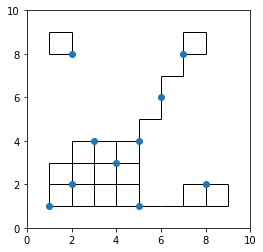

In [14]:
G = make_graph_plot(Nx0 = 40, L = 10, alpha = 0.8, points = points)

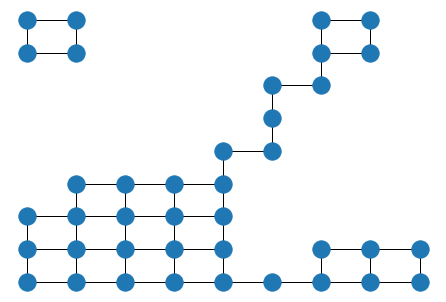

In [15]:
# networkx draw
nx.draw(G, pos=dict( (n, n) for n in G.nodes() ))

### different approach: algo & plot

In [16]:
set_points(G, points)

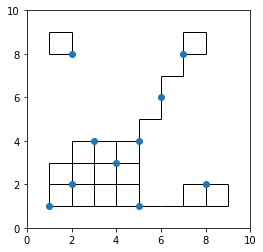

In [17]:
plot_graph(G)

# Example 2
Points selected at random. Try varying alpha for different results. Higher alpha includes more edges

In [18]:
points2 = np.random.randint(18, size=(40, 2)) + 1

number of original edges 684
number of final edges 134


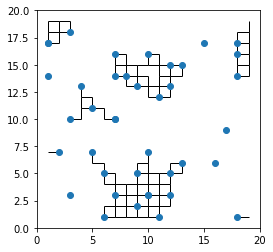

In [19]:
make_graph_plot(Nx0 = 40, L = 20, alpha = 0.8, points = points2)

## K-means clustering

Example taken from 

https://benalexkeen.com/k-means-clustering-in-python/

In [20]:
def make_clusters(k: int, points: List[Point]):
    xpoints = [point[0] for point in points]
    ypoints = [point[1] for point in points]

    df = pd.DataFrame({
        'x': xpoints,
        'y': ypoints
    })
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df);

    labels = kmeans.predict(df)
    centroids = kmeans.cluster_centers_
    
    return df, labels, centroids

number of original edges 144
number of final edges 52


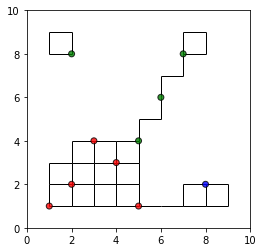

In [21]:
points = [[1, 1], [2, 2], [3, 4], [5, 1], [5, 4], [8, 2], [7, 8], [6,  6] , [2, 8], [4,3] ]

# k-means clustering
df, labels, centroids = make_clusters(3, points)
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'y', 5: 'k', 6: 'm'}
colors = list(map(lambda x: colmap[x+1], labels))

# landscape clustering
G = make_graph(40, 10, 0.8, points)
pos = dict( (n, n) for n in G.nodes() )

# make plots
fig, ax = plt.subplots(figsize=(4,4)); plt.xlim(0, 10); plt.ylim(0, 10);

nx.draw_networkx_edges(G, pos, ax = ax, with_labels = False)
plt.scatter(df['x'], df['y'], c = colors, alpha=0.8, edgecolor='k')

In [22]:
L0 = 25; Npts = 120; 
points2 = np.random.randint(L0 - 2, size=(Npts, 2)) + 1

number of original edges 1104
number of final edges 429


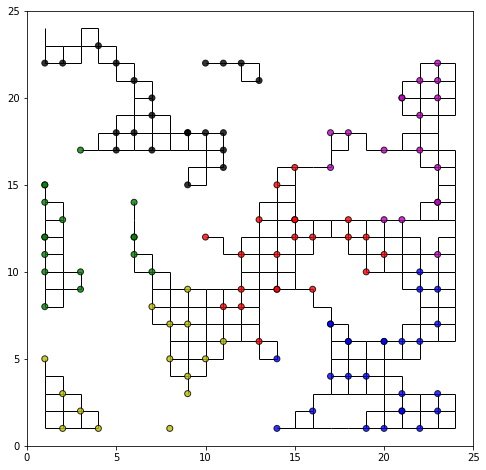

In [23]:
kcluster = 6; alpha_cutoff = 0.7;

# k-means clustering
df, labels, centroids = make_clusters(kcluster, points2)
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'y', 5: 'k', 6: 'm'}
colors = list(map(lambda x: colmap[x+1], labels))

# landscape clustering
G = make_graph(60, L0, alpha_cutoff, points2)
pos = dict((n, n) for n in G.nodes() )

# make plots
fig, ax = plt.subplots(figsize=(8,8)); plt.xlim(0, L0); plt.ylim(0, L0);

nx.draw_networkx_edges(G, pos, ax = ax, with_labels = False)
plt.scatter(df['x'], df['y'], c = colors, alpha = 0.8, edgecolor='k')

advantages of landscape vs k-means:

- takes care of edges, ensuring that each cluste is always connected

- takes into account 'local density', so it naturally avoids holes. This can be alleviated in k-means by adding more clusters, but then we have to combine the clusters by some other means

guidelines:

- at high density, take alpha_cutoff small

things to try:

- add/remove edges with the mouse? 

# Steiner tree

## Example 1

In [24]:
points = [(1, 1), (2, 2), (3, 4), (5, 1), (5, 4), (8, 2), (7, 8), (6,  6), (2,8), (4,3) ]

In [25]:
G = nx.grid_2d_graph(range(1,int(10)), range(1,int(10))) 

The number of edges of the Steiner tree is 26


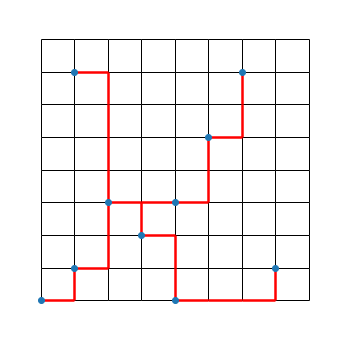

In [26]:
make_naive_steiner_plot(G, L = 10, points = points)

### different approach: algo & plot

In [27]:
G_st = get_naive_steiner(G, points=points)

The number of edges of the Steiner tree is 26


In [28]:
set_points(G, points)

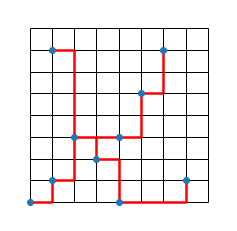

In [29]:
plot_graph(G, tree=G_st)

number of original edges 144
number of final edges 52
The total number of edges of the Steiner trees is 21


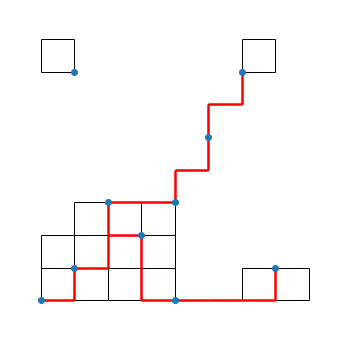

In [30]:
make_improved_steiner_plot(G, 10, 0.8, points)

## Example 2

In [31]:
L = 40
points2 = [(np.random.randint(L-2) + 1, np.random.randint(L-2) + 1) for i in range(250) ]
G = nx.grid_2d_graph(range(1,int(L)), range(1,int(L))) 

The number of edges of the Steiner tree is 465


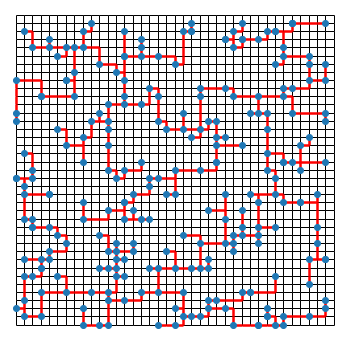

In [32]:
make_naive_steiner_plot(G, L, points = points2)

number of original edges 2964
number of final edges 1176
The total number of edges of the Steiner trees is 409


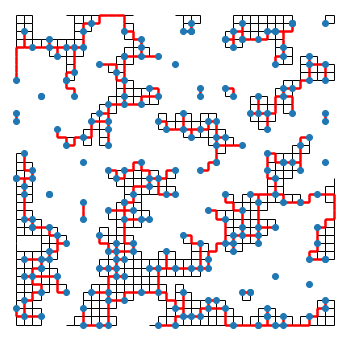

In [33]:
make_improved_steiner_plot(G, L, 1.5, points2)